### Importing Libraries

In [1]:
import os
import csv
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
seed = 0
np.random.seed(seed)

from scipy.sparse import lil_matrix, linalg, csgraph
from sklearn.cluster import KMeans

In [2]:
save_dir = "./assets/assignment2/"
ques = ["Q1/", "Q2/", "Q3/", "Q4/"]
save_dirs = [save_dir + q for q in ques]
for save_dir in save_dirs:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

## Question 1

Q1. Implement the greedy algorithm for the densest subgraph. Run your algorithm on the [linked dataset](https://snap.stanford.edu/data/facebook-large-page-page-network.html). Report the density of the component extracted, as well as the histogram of the page categories in the densest subgraph. Also report the overall histogram of page categories and comment on how similar/different the two histograms are. Also compare its density with the density of the whole graph.


In [3]:
facebook_root = "./data/facebook_large/"
target_file = facebook_root + "musae_facebook_target.csv"
edges_file = facebook_root + "musae_facebook_edges.csv"

In [ ]:
node_attrs = {}
with open(target_file, newline='', encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        node_attrs[int(row['id'])] = {
            'facebook_id': row['facebook_id'],
            'page_name': row['page_name'],
            'page_type': row['page_type']
        }
num_nodes = len(node_attrs)
print(f"Number of nodes (loaded from target file): {num_nodes}")

edges_df = pd.read_csv(edges_file)
num_nodes = max(edges_df['id_1'].max(), edges_df['id_2'].max()) + 1
print(f"Number of nodes (determined from edges file): {num_nodes}")

adj_matrix = lil_matrix((num_nodes, num_nodes), dtype=np.int8)
for src, dst in tqdm(zip(edges_df['id_1'], edges_df['id_2']), total=len(edges_df), desc="Loading edges"):
    adj_matrix[src, dst] = 1
    adj_matrix[dst, src] = 1

# Convert to CSR format for faster operations
adj_matrix = adj_matrix.tocsr()
print(f"\nAdjacency matrix shape: {adj_matrix.shape}")

# check number of edges in adjacency matrix, also count self loops 
num_edges = adj_matrix.sum() // 2 + adj_matrix.diagonal().sum() // 2
print(f"Number of edges (in adjacency matrix): {num_edges}")
# check number of nodes in adjacency matrix
print(f"Number of nodes (in adjacency matrix): {adj_matrix.shape[0]}")

Number of nodes (loaded from target file): 22470
Number of nodes (determined from edges file): 22470


Loading edges: 100%|██████████| 171002/171002 [00:01<00:00, 116038.04it/s]



Adjacency matrix shape: (22470, 22470)
Number of edges (in adjacency matrix): 171001
Number of nodes (in adjacency matrix): 22470


In [6]:
# count number of self loops
self_loops = adj_matrix.diagonal().sum()
print(f"Number of self loops: {self_loops}")

Number of self loops: 179


In [51]:
# different categories of page types
page_types = set()
for node in node_attrs.values():
    page_types.add(node['page_type'])
page_types = sorted(list(page_types))
print(f"Page types: {page_types}")

Page types: ['company', 'government', 'politician', 'tvshow']


In [52]:
# Compute graph density
def calculate_density(adj_matrix, active_mask=None):
    if active_mask is None:
        active_mask = np.ones(adj_matrix.shape[0], dtype=bool)
    num_active_nodes = active_mask.sum()
    if num_active_nodes == 0:
        return 0.0
    num_edges = adj_matrix[active_mask][:, active_mask].sum() / 2
    return num_edges / num_active_nodes

# Greedy densest subgraph algorithm
def greedy_densest_subgraph(adj_matrix):
    active_mask = np.ones(num_nodes, dtype=bool)
    degrees = degrees = adj_matrix.sum(axis=1).astype(float)  # Ensure float dtype
    max_density = calculate_density(adj_matrix, active_mask)
    best_active_mask = active_mask.copy()
    removal_order = []
    densities = [max_density]
    
    with tqdm(total=num_nodes, desc="Removing nodes") as pbar:
        while active_mask.sum() > 0:
            min_degree_node = np.argmin(degrees)
            active_mask[min_degree_node] = False  # Remove node
            neighbors = adj_matrix[min_degree_node].nonzero()[1]
            degrees[neighbors] -= 1  # Update degrees
            degrees[min_degree_node] = np.inf  # Mark removed node
            removal_order.append(min_degree_node)
            
            current_density = calculate_density(adj_matrix, active_mask)
            densities.append(current_density)
            if current_density > max_density:
                max_density = current_density
                best_active_mask = active_mask.copy()
            
            pbar.set_postfix_str(f"Best density: {max_density:.4f}")
            pbar.update(1)
    
    return best_active_mask, max_density, removal_order, densities

In [53]:
run_greedy = False  # Set to True to run the greedy algorithm
if run_greedy:
    best_active_mask, max_density, removal_order, densities = greedy_densest_subgraph(adj_matrix)
    np.save(save_dirs[0] + "best_active_mask.npy", best_active_mask)
    np.save(save_dirs[0] + "removal_order.npy", removal_order)
    np.save(save_dirs[0] + "densities.npy", densities)
else:
    best_active_mask = np.load(save_dirs[0] + "best_active_mask.npy")
    best_active_mask = best_active_mask.astype(bool)
    removal_order = np.load(save_dirs[0] + "removal_order.npy")
    densities = np.load(save_dirs[0] + "densities.npy")
    max_density = densities.max()

Densest Subgraph Staatistics:
    Number of nodes: 320
    Number of edges: 11201
    Density: 35.003125


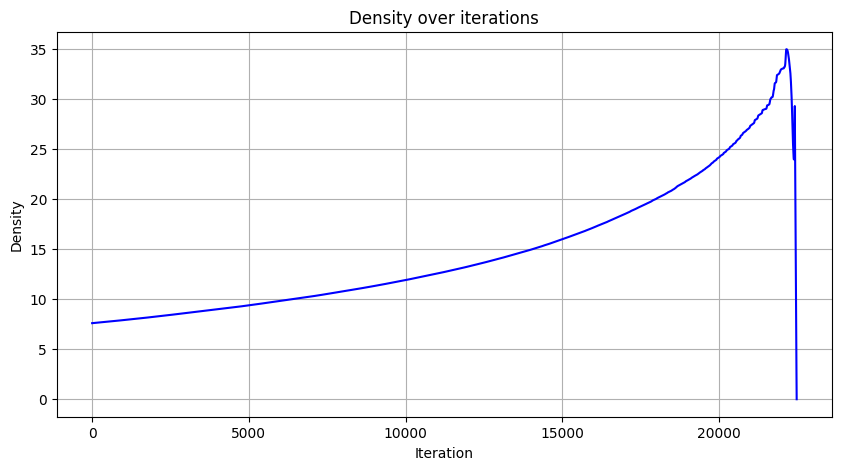

In [54]:
print("Densest Subgraph Staatistics:")
print(f"    Number of nodes: {best_active_mask.sum()}")
print(f"    Number of edges: {int(adj_matrix[best_active_mask][:, best_active_mask].sum() / 2)}")
print(f"    Density: {max_density}")
# print(f"    Removal order: {list(removal_order)}")

# Plotting the density over iterations
plt.figure(figsize=(10, 5))
plt.plot(densities, color='blue')
plt.title('Density over iterations')
plt.xlabel('Iteration')
plt.ylabel('Density')
plt.grid()
plt.savefig(save_dirs[0] + "density_over_iterations.png", dpi=300)
plt.show()

In [55]:
print(f"Density of the entire graph    : {calculate_density(adj_matrix):.4f}")
print(f"Density of the densest subgraph: {max_density:.4f}")

Density of the entire graph    : 7.6063
Density of the densest subgraph: 35.0031


Category counts in the whole graph:
    company: 6495
    government: 6880
    politician: 5768
    tvshow: 3327
Category counts in the densest subgraph:
    company: 4
    government: 256
    politician: 0
    tvshow: 60


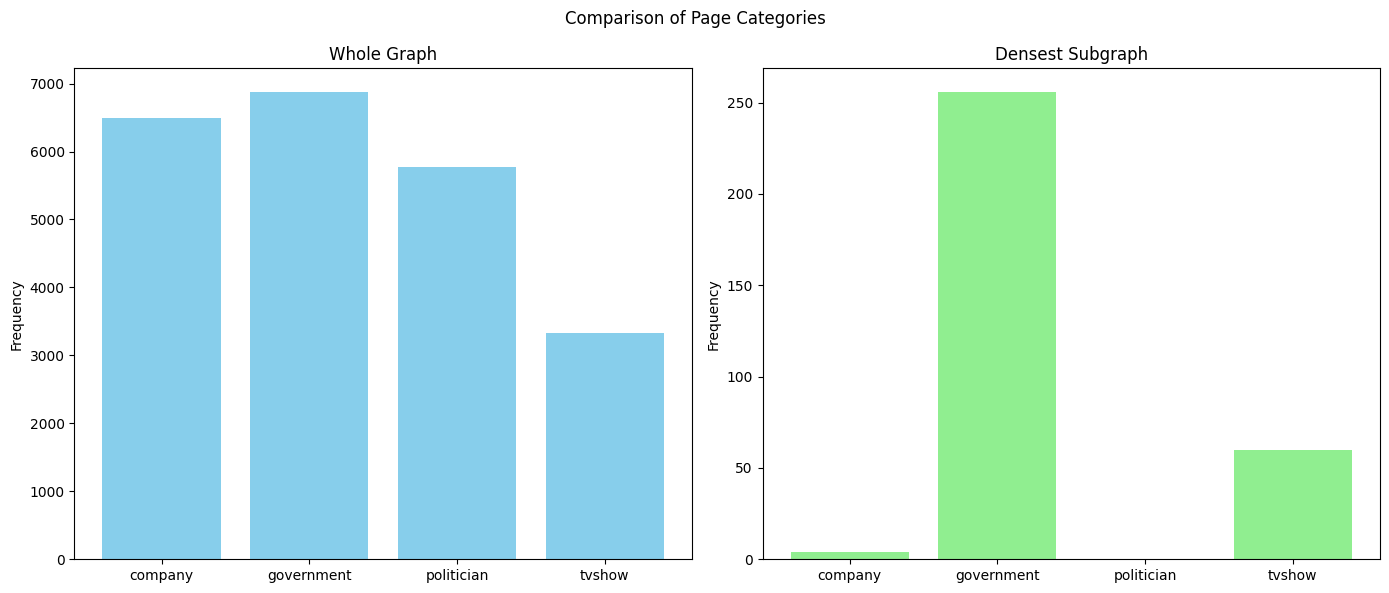

In [56]:
def plot_category_histograms(node_attrs, full_mask, densest_mask, save_path):
    # Extract category counts
    full_categories = [node_attrs[node]['page_type'] for node in np.where(full_mask)[0]]
    densest_categories = [node_attrs[node]['page_type'] for node in np.where(densest_mask)[0]]
    full_counts = Counter(full_categories)
    densest_counts = Counter(densest_categories)
    
    # Ensure both histograms have the same categories
    all_categories = sorted(set(full_counts.keys()).union(set(densest_counts.keys())))
    full_freqs = [full_counts.get(cat, 0) for cat in all_categories]
    densest_freqs = [densest_counts.get(cat, 0) for cat in all_categories]

    # Print category counts
    print("Category counts in the whole graph:")
    for cat, count in zip(all_categories, full_freqs):
        print(f"    {cat}: {count}")
    print("Category counts in the densest subgraph:")
    for cat, count in zip(all_categories, densest_freqs):
        print(f"    {cat}: {count}")

    # Plot histograms
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))             # add sharey=True to share y-axis
    axes[0].bar(all_categories, full_freqs, color='skyblue')
    axes[0].set_title("Whole Graph")
    axes[0].set_ylabel("Frequency")
    axes[1].bar(all_categories, densest_freqs, color='lightgreen')
    axes[1].set_title("Densest Subgraph")
    axes[1].set_ylabel("Frequency")
    fig.suptitle("Comparison of Page Categories")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_category_histograms(node_attrs, np.ones(num_nodes, dtype=bool), best_active_mask, save_dirs[0] + "category_histogram_comparison.png")